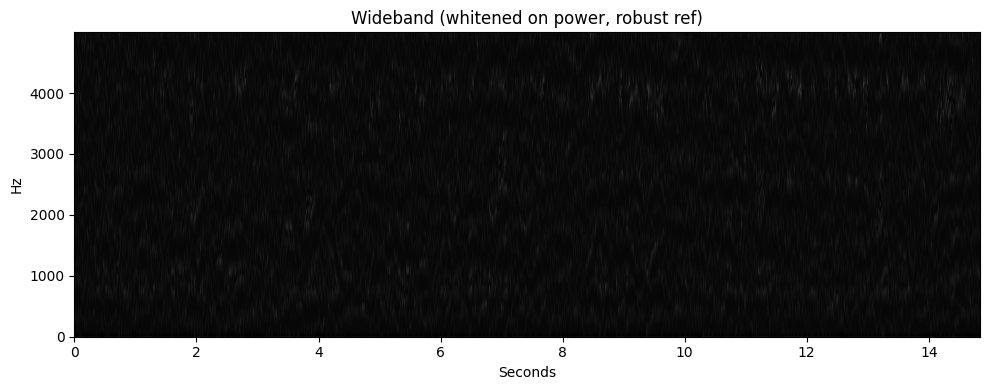

In [16]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def preemphasis_np(x, alpha=0.97):
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - alpha * x[:-1]
    return y

def praatish_wideband(x, sr,
                      win_ms=5.0, hop_ms=1.0,
                      n_fft=2048, fmax=5000,
                      top_db=55.0, preemph=0.97,
                      whiten_hz=300.0,
                      tf_smooth=(5, 5)):
    x = preemphasis_np(x, preemph)

    win_length = int(sr * win_ms / 1000.0)
    hop_length = int(sr * hop_ms / 1000.0)

    # Power spectrogram (linear)
    S = np.abs(librosa.stft(
        x, n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hann",
        center=True
    ))**2

    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    df = freqs[1] - freqs[0]

    # Smooth spectral envelope per frame on *linear* power, then divide (whiten)
    k = int(max(5, round(whiten_hz / df)))
    if k % 2 == 0:
        k += 1
    ker_f = np.ones(k, dtype=np.float32) / k

    env = np.apply_along_axis(lambda v: np.convolve(v, ker_f, mode="same"), 0, S)
    S_w = S / (env + 1e-12)

    # Light TF smoothing to suppress speckle
    kt, kf = tf_smooth
    if kt > 1:
        ker_t = np.ones(kt, dtype=np.float32) / kt
        S_w = np.apply_along_axis(lambda v: np.convolve(v, ker_t, mode="same"), 1, S_w)
    if kf > 1:
        ker_ff = np.ones(kf, dtype=np.float32) / kf
        S_w = np.apply_along_axis(lambda v: np.convolve(v, ker_ff, mode="same"), 0, S_w)

    # Convert to dB with a robust reference
    # Use a high percentile so one loud frame doesn't dominate, and speckle doesn't set vmax.
    ref = np.percentile(S_w, 99.9)
    S_db = 10.0 * np.log10((S_w / (ref + 1e-12)) + 1e-12)

    # Clip like a display (top_db below 0 dB)
    vmax = 0.0
    vmin = -top_db
    S_db = np.clip(S_db, vmin, vmax)

    # Limit frequency range
    keep = freqs <= fmax
    S_db = S_db[keep]
    freqs = freqs[keep]

    times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length)
    return S_db, freqs, times, vmin, vmax

def plot_spec(S_db, freqs, times, vmin, vmax, title=""):
    plt.figure(figsize=(10, 4))
    plt.imshow(
        S_db, origin="lower", aspect="auto",
        interpolation="none",
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap="gray_r",
        vmin=vmin, vmax=vmax
    )
    plt.xlabel("Seconds")
    plt.ylabel("Hz")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Speech sample
x, sr = librosa.load(librosa.ex("libri1"), sr=None, mono=True)

S_db, freqs, times, vmin, vmax = praatish_wideband(
    x, sr,
    win_ms=5.0, hop_ms=1.0,
    n_fft=2048,
    whiten_hz=200.0,
    top_db=55.0,
    fmax=5000
)
plot_spec(S_db, freqs, times, vmin, vmax, title="Wideband (whitened on power, robust ref)")
